#### Training Sample: train.csv with oversampling
#### Evaluation Sample: validation_under.csv
#### Method: OOB
#### Output: Best hyperparameters; Pr-curve; ROC AUC

# Training Part 

In [24]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc,f1_score,make_scorer,classification_report, matthews_corrcoef, accuracy_score, average_precision_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

#### Input data is read and named as the following

In [2]:
transactions = pd.read_csv('../Data/train.csv')
X_train = transactions.drop(labels='Class', axis=1)
y_train = transactions.loc[:,'Class']

In [3]:
rus = RandomOverSampler(sampling_strategy=0.8)
X_res, Y_res = rus.fit_resample(X_train, y_train)

#### Tuning parameters

In [4]:
test = 1
rf = RandomForestClassifier(n_jobs=-1, random_state=1)

if test== 0:
    n_estimators = [75,150,800,1000,1200]
    min_samples_split = [2, 5]
    min_samples_leaf = [1, 5]
else:
    n_estimators = [800]
    min_samples_split = [2]
    min_samples_leaf = [1]

param_grid_rf = {'n_estimators': n_estimators,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'oob_score': [True]
                }

In [5]:
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,cv = 5,
                       n_jobs=-1, pre_dispatch='2*n_jobs', verbose=1, return_train_score=False)


In [6]:
grid_rf.fit(X_res,  Y_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'min_s

#### The best score and the estimator

In [7]:
grid_rf.best_score_

0.9999128204974042

In [8]:
grid_rf.best_params_

{'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800,
 'oob_score': True}

In [11]:
y_pre = grid_rf.predict(X_res)
print('Classification Report for training')
print(classification_report(y_pre, Y_res))

Classification Report for training
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    184804
           1       1.00      1.00      1.00    147843

    accuracy                           1.00    332647
   macro avg       1.00      1.00      1.00    332647
weighted avg       1.00      1.00      1.00    332647



# Evaluation Part 

In [12]:
evaluation = pd.read_csv('../Data/validation_under.csv')
X_eval = evaluation.drop(labels='Class', axis=1)
y_eval = evaluation.loc[:,'Class']

In [13]:
def Random_Forest_eval(estimator, X_test, y_test):
    
    y_pred = estimator.predict(X_test)

    print('Classification Report')
    print(classification_report(y_test, y_pred))
    y_score = estimator.predict_proba(X_test)[:,1]
    print('AUPRC', average_precision_score(y_test, y_score))
    print('AUROC', roc_auc_score(y_test, y_score))
    

In [14]:
Random_Forest_eval(grid_rf, X_eval, y_eval)

Classification Report
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       173
           1       1.00      0.79      0.88       173

    accuracy                           0.89       346
   macro avg       0.91      0.89      0.89       346
weighted avg       0.91      0.89      0.89       346

AUPRC 0.9696175185145255
AUROC 0.9687761034448193


###  Receiver Operating Characteristic Curve

In [15]:
def Draw_ROC(Y_prob, Y_observed, model_name = 'Model'):
    ns_probs = [0 for _ in range(len(Y_observed))]
    # calculate scores
    ns_auc = roc_auc_score(Y_observed, ns_probs)
    lr_auc = roc_auc_score(Y_observed, Y_prob)
    # summarize scores
    print('Chance: ROC AUC=%.3f' % (ns_auc))
    print('%s: ROC AUC=%.3f' % (model_name, lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(Y_observed, ns_probs, pos_label=1)
    lr_fpr, lr_tpr, _ = roc_curve(Y_observed, Y_prob, pos_label=1)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Chance')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.title('Receiver operating characteristic curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

### Precision Recall Curve

Chance: ROC AUC=0.500
Random Forest: ROC AUC=0.969


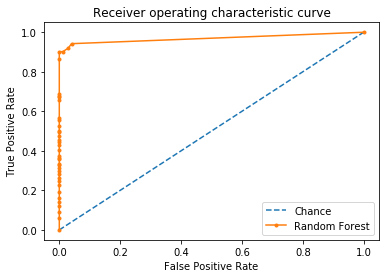

In [21]:
y_score = grid_rf.predict_proba(X_eval)[:,1]

Draw_ROC(y_score, y_eval,'Random Forest')

In [22]:
def Draw_PR(Y_prob, Y_predicted, Y_observed, model_name = 'Model'):
    # predict class values
    lr_precision, lr_recall, _ = precision_recall_curve(Y_observed, Y_prob, pos_label=1)
    lr_f1, lr_auc = f1_score(Y_observed, Y_predicted), auc(lr_recall, lr_precision)
    # summarize scores
    print('Random Forest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(Y_observed[Y_observed==1]) / len(Y_observed)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Chance')
    plt.plot(lr_recall, lr_precision, marker='.', label=model_name)
    # axis labels
    plt.title('2-class Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

Random Forest: f1=0.880 auc=0.983


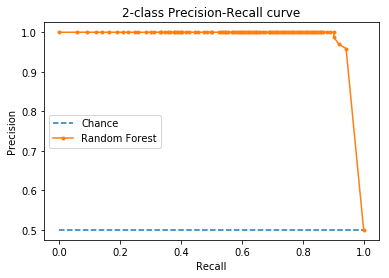

In [25]:
Y_predicted = grid_rf.predict(X_eval)
Draw_PR(y_score, Y_predicted, y_eval,'Random Forest')